In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn import preprocessing,metrics,manifold
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict
from imblearn.over_sampling import ADASYN,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import collections
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import RobustScaler
import xgboost
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from IPython.display import display
pd.set_option('display.max_colwidth',-1)
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [12]:
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',names=['target','id','date','flag','user','text'],index_col=False)

In [13]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
col=['id','date','flag','user']
data.drop(col,axis=1,inplace=True)


In [15]:
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Total counts of both sides:
 0    800000
4    800000
Name: target, dtype: int64


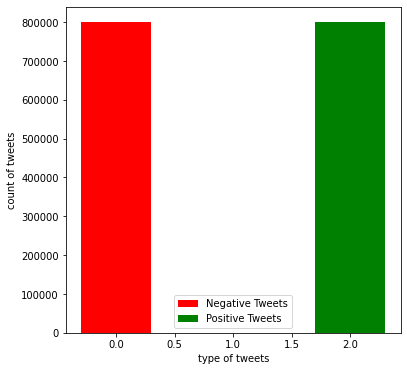

In [21]:
count=data['target'].value_counts()
print('Total counts of both sides:\n',count)
print('===============================================')
def plot_counts(n_d,d):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,d,width=0.6,label='Negative Tweets',color='red')
    plt.bar(2,n_d,width=0.6,label='Positive Tweets',color='green')
    plt.legend()
    plt.ylabel('count of tweets')
    plt.xlabel('type of tweets')
    plt.show()

count_dis=data[data['target']==0]
count_non_dis=data[data['target']==4]
plot_counts(len(count_dis),len(count_non_dis))

Negative tweets words:
 0         19
1         21
2         18
3         10
4         21
          ..
799995    10
799996    3 
799997    6 
799998    17
799999    15
Name: text, Length: 800000, dtype: int64
Positive tweets words:
 800000     8 
800001     14
800002     27
800003     21
800004     7 
          .. 
1599995    11
1599996    11
1599997    11
1599998    12
1599999    5 
Name: text, Length: 800000, dtype: int64


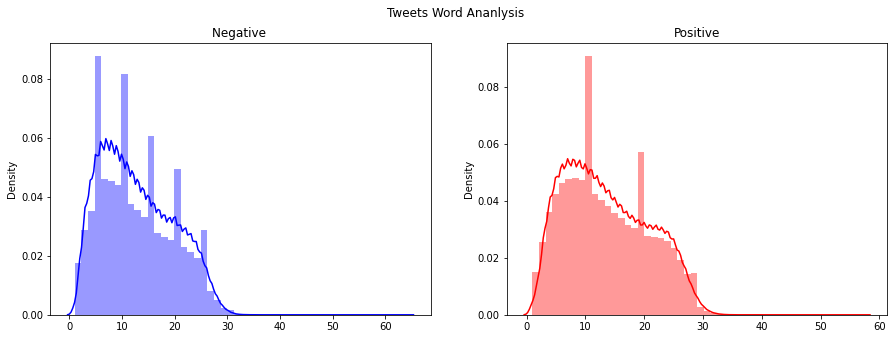

In [22]:
def cal_len(data):
    return len(data)

def plot_count(count_ones,count_zeros,title1,title2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title1)
    sns.distplot(count_ones,ax=ax2,color='red')
    ax2.set_title(title2)
    fig.suptitle(subtitle)
    plt.show()
count_d=count_dis['text'].str.split().apply(lambda x:cal_len(x))
count_n_d=count_non_dis['text'].str.split().apply(lambda x:cal_len(x))
print('Negative tweets words:\n',str(count_d))
print('Positive tweets words:\n',str(count_n_d))
plot_count(list(count_d),list(count_n_d),'Negative ','Positive','Tweets Word Ananlysis')

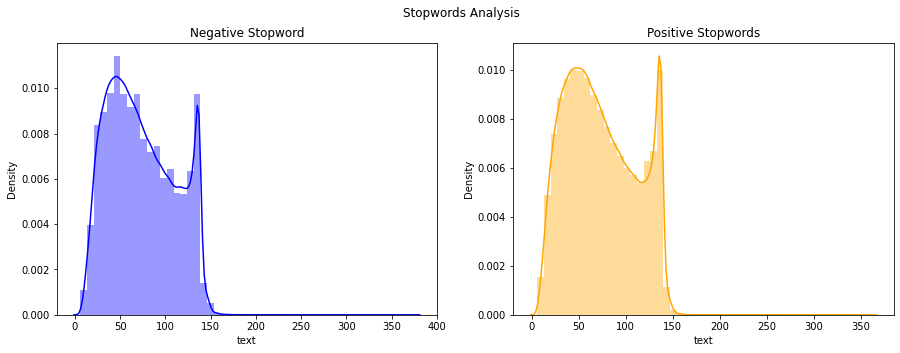

In [24]:
#Analyse Stopwords

def plot_count_1(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(count_ones,ax=ax2,color='Orange')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


stops=set(stopwords.words('english'))
count_good_stops=count_dis['text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
count_bad_stops=count_non_dis['text'].apply(lambda z : np.mean([len(z) for w in str(z).split()]))
plot_count_1(count_good_stops,count_bad_stops,"Negative Stopword","Positive Stopwords","Stopwords Analysis")

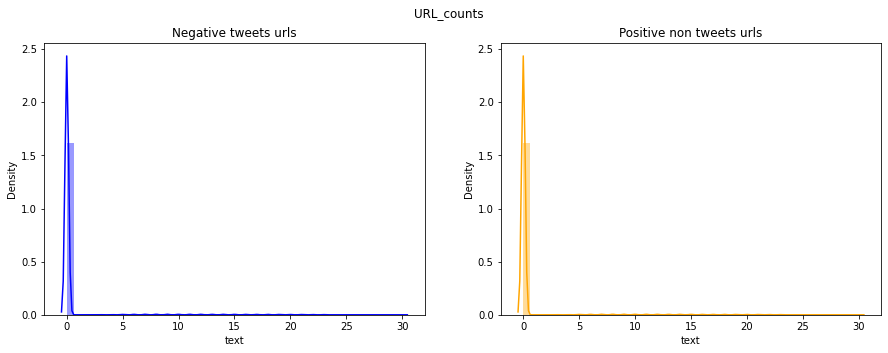

In [25]:
def plot(count_ones,count_zersos,title1,title2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count_ones,ax=ax1,color='Blue')
    ax1.set_title(title1)
    sns.distplot(count_ones,ax=ax2,color='Orange')
    ax2.set_title(title2)
    fig.suptitle(subtitle)
    plt.show()
count_d_url=count_dis['text'].apply(lambda x:len([c for c in str(x).split() if 'http' in x or 'https' in x]))
count_nd_url=count_non_dis['text'].apply(lambda x:len([c for c in str(x).split() if 'http' in x or 'https' in x]))

plot(count_d_url,count_nd_url,'Negative tweets urls','Positive non tweets urls','URL_counts')

<AxesSubplot:>

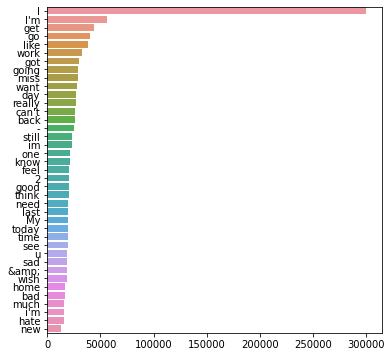

In [27]:
#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in data[data['target']==word]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(0)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)